<a href="https://colab.research.google.com/github/karlssoj/cv26/blob/Exemple1_XY_classification/X_Y_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1> Klassificeringsexempel med faltningsnätverk (CNN) implementerat med Keras och Tensorflow </h1>

I det här simpla exemplet tränar vi in en modell att kunna se skillnad mellan X och O. I katalogen X_O_training finns 2 kataloger O och X. Vardera katalog innehåller 34 träningsbilder på X respektive O. Sedan har vi också en annan katalog X_O_test som innehåller 10 stycen X och 10 stycken 0. Dessa används för att validera modellens prestanda

Skriptet är testkört i google colab (men kan nog även köras lokalt).

**Börjar med att klona repon så att vi får med alla filer**

In [1]:
!git clone https://github.com/karlssoj/cv26.git

Cloning into 'cv26'...
remote: Enumerating objects: 119, done.
remote: Counting objects: 100% (119/119), done.
remote: Compressing objects: 100% (110/110), done.
remote: Total 119 (delta 11), reused 109 (delta 7), pack-reused 0 (from 0)
Receiving objects: 100% (119/119), 584.26 KiB | 3.65 MiB/s, done.
Resolving deltas: 100% (11/11), done.


<b> Importerar OpenCV och Matplotlib



In [2]:
import matplotlib.pyplot as plt
import cv2 as cv

<b> Importerar ImageDataGenerator från Keras-biblioteket för att kunna hantera träningsbilderna

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

<b> Skapar ett ImageDataGenerator-objekt med vissa inställningar för data augumentering

In [4]:
image_gen = ImageDataGenerator(rotation_range=30,    #slumpmässiga roteringar av bilderna i grader
                             width_shift_range=0.1,  #slumpmässig skiftning i x-led (ett värde mellan 0 och 1)
                             height_shift_range=0.1, #slumpmässig skiftning i y-led (ett värde mellan 0 och 1)
                             rescale=1/255,          #skalar ner ett 8-bitars pixelvärde (0-255) till ett värde mellan 0 och 1
                             zoom_range=0.6,         #slumpmässig zoom
                             horizontal_flip=True)   #"flippar" bilden slumpmässigt i horisontalt läge

<B> Delar in träningsbilderna i validation 20% och training 80% samt läser även in testbilderna till objektet test_image_gen

In [5]:
image_gen = ImageDataGenerator(rescale=1/255, validation_split=0.2)

train_image_gen = image_gen.flow_from_directory('/content/cv26/X_O_training',
                                                target_size=(100,100),
                                                subset='training')

val_image_gen = image_gen.flow_from_directory('/content/cv26/X_O_training',
                                              target_size=(100,100),
                                              subset='validation')  # 20% val

test_image_gen = image_gen.flow_from_directory('/content/cv26/X_O_test',
                                               target_size=(100,100))  # 20% test


Found 54 images belonging to 2 classes.
Found 12 images belonging to 2 classes.
Found 20 images belonging to 2 classes.


<b> Träningsbilderna har automatiskt markerats enligt namnet på katalogerna de finns sparade i, dvs. O har labeln 0 och X har labeln 1

In [6]:
print(train_image_gen.class_indices)

{'O': 0, 'X': 1}


<b> Importerar behövliga bibliotek från Keras för att kunna skapa en CNN-modell

In [7]:
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Input

<b> Skapar ett faltningslager (convolutional layer) bestående av 32 olika filters. Som aktiveringsfunktion används ReLU (för att bli av med alla negativa pixelvärden<br><br>

<b> Kör MaxPooling med 2x2 fönsterstorlek och hopp (stride) = 2<br><br>

<b> Formaterar om alla filtrerade bilder (i detta fall 32 stycken) till en enda array = flatten<br><br>

<b> Till slut mynnar allt ut i 2 neuroner i "fully connected layer", en för X och en för Y

In [8]:
model = Sequential()
model.add(Input(shape=(100, 100, 3)))
model.add(Conv2D(32, (3, 3), activation='relu'))                            #Faltningslager med 32 filter
model.add(MaxPooling2D(pool_size = (2, 2)))                                 #MaxPooling 2x2 fönsterstorlek och hopp (stride) = 2

model.add(Flatten())                                                        #Formaterar om alla filtrerade blder (32 stycken) till en array
model.add(Dense(units = 2, activation = "sigmoid"))                         #2 neuroner på slutet

<b> "Kompilerar" modellen och definierar loss function och optimizer

In [9]:
model.compile(optimizer = 'adam',
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

In [10]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 98, 98, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 49, 49, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 76832)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2)              │       153,666 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 154,562 (603.76 KB)

 Trainable params: 154,562 (603.76 KB)

 Non-trainable params: 0 (0.00 B)

<b> Startar själva inträning. Epochs definierar hur många ggr inlärningsalgoritmen kommer att gå igenom hela datasetet. Vi definierar även var valideringsbilderna finns som ska tas i beaktand under inträning

In [11]:
results = model.fit(train_image_gen,
                    validation_data=val_image_gen,
                    epochs=50)

Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 730ms/step - accuracy: 0.5550 - loss: 2.1942 - val_accuracy: 0.5000 - val_loss: 2.4935
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.5104 - loss: 3.1277 - val_accuracy: 0.5000 - val_loss: 3.3476
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - accuracy: 0.5370 - loss: 3.1404 - val_accuracy: 0.5000 - val_loss: 2.0226
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - accuracy: 0.4394 - loss: 1.9400 - val_accuracy: 0.5000 - val_loss: 1.8647
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - accuracy: 0.4669 - loss: 1.7265 - val_accuracy: 0.9167 - val_loss: 1.4988
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - accuracy: 0.8737 - loss: 1.1183 - val_accuracy: 0.5000 - val_loss: 0.8123
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - accuracy: 0.6291 - loss: 0.6735 - val_accuracy: 0.7500 - val_loss: 0.7655
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - accuracy: 0.7952 - loss: 0.5963 - val_accuracy: 0.8333 - val_loss: 0.6593
Epo

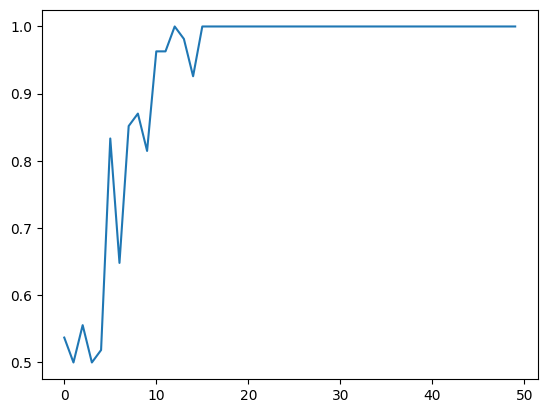

In [12]:
plt.plot(results.history['accuracy'])

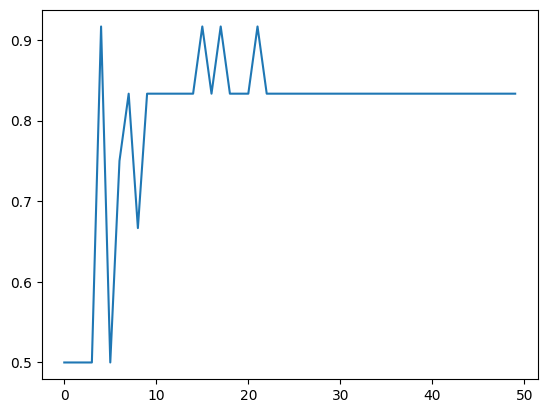

In [13]:
plt.plot(results.history['val_accuracy'])

<b> Vi laddar in en testbild (En bild som inte finns i träningsdataset:en) för att se hur bra vår modell fungerar!

In [19]:
import numpy as np
import keras.utils as image
test_image = '/content/cv26/test_image2.jpg'
test_image = image.load_img(test_image, target_size=(100,100)) #laddar testbilden och sätter storleken till samma som träningsbilderna
test_image = image.img_to_array(test_image)                    #konverterar till array-format

test_image = np.expand_dims(test_image, axis=0)
test_image = test_image/255                                    #Ändrar pixelvärden från 8-bitar (0-255) till värden mellan 0 och 1

<b> Vi startar "predikteringen" dvs. Som svar får vi konfidensvärden som berättar hur stor sannolikhten är att bilden innehåller ett X och hur stor sannolikheten är att bilden innehåller ett O

In [20]:
prob = model.predict(test_image)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


In [21]:
print(prob)

[[0.09591425 0.9391986 ]]


In [22]:
print("Sannolikheten att testbilden innehåller O: " + str(prob[0][0]))
print("Sannolikheten att testbilden innehåller X: " + str(prob[0][1]))

Sannolikheten att testbilden innehåller O: 0.09591425
Sannolikheten att testbilden innehåller X: 0.9391986


<B> Evaluerar vår klassificeringsmodell mot testdatasetet

In [23]:
test_loss, test_acc = model.evaluate(test_image_gen)
print(f"Test Accuracy: {test_acc:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.6500 - loss: 0.7203
Test Accuracy: 0.6500
